In [43]:
from lightglue import LightGlue, SuperPoint, DISK, SIFT, ALIKED, DoGHardNet
from lightglue.utils import load_image, rbd

# SuperPoint+LightGlue
extractor = SuperPoint(max_num_keypoints=2048).eval()  # load the extractor
matcher = LightGlue(features='superpoint').eval() # load the matcher

image_path0 = "../assets/database/20151108_225523.jpg"
image_path1 = "../assets/queries/a.jpg"

# load each image as a torch.Tensor on GPU with shape (3,H,W), normalized in [0,1]
image0 = load_image(image_path0)
image1 = load_image(image_path1)

# extract local features
feats0 = extractor.extract(image0)  # auto-resize the image, disable with resize=None
feats1 = extractor.extract(image1)

# match the features
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
matches = matches01['matches']  # indices with shape (K,2)
points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

In [44]:
matches01['scores'] 

tensor([0.1985, 0.5356, 0.4013, 0.1145, 0.2696, 0.1406, 0.4550, 0.1220, 0.2262,
        0.2466, 0.1355, 0.1131, 0.1709, 0.1552, 0.3045, 0.4959, 0.1020, 0.1319,
        0.1344, 0.3269, 0.1771, 0.1642, 0.1713, 0.2986, 0.3556, 0.1011, 0.1547,
        0.1257, 0.1184, 0.1707, 0.2050], grad_fn=<IndexBackward0>)

In [ ]:
scores = matches01['scores']          # (K,)
matches = matches01['matches']        # (K, 2)

# threshold (tune this)
score_thresh = 0.7

mask = scores > score_thresh

matches = matches[mask]
scores  = scores[mask]

points0 = feats0['keypoints'][matches[:, 0]]
points1 = feats1['keypoints'][matches[:, 1]]


In [ ]:
from lightglue import viz2d
kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

In [92]:
from lightglue import LightGlue, SuperPoint, DISK, SIFT, ALIKED, DoGHardNet
from lightglue.utils import load_image, rbd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = SuperPoint(max_num_keypoints=256, detection_threshold=0.02).eval().to(device)
matcher = LightGlue(features='superpoint').eval().to(device)

# extractor = DISK(max_num_keypoints=128, detection_threshold=0.85).eval().to(device)
# matcher = LightGlue(features='disk').eval().to(device)

def light_glue_checker(extractor, matcher, device, image_path0, image_path1, score_threshold=0.85):
    image0 = load_image(image_path0).to(device)
    image1 = load_image(image_path1).to(device)

    feats0 = extractor.extract(image0)
    feats1 = extractor.extract(image1)

    print("--------------------------------")
    print("after extraction")
    print("--------------------------------")

    # --- match ---
    matches01 = matcher({'image0': feats0, 'image1': feats1})

    # remove batch dimension
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]

    # =========================
    # SCORE THRESHOLDING (0.7)
    # =========================
    score_thresh = 0.8

    scores  = matches01['scores']     # (K,)
    matches = matches01['matches']    # (K, 2)

    mask = scores > score_thresh

    matches = matches[mask]
    scores  = scores[mask]

    # update matches01 so viz2d uses filtered matches
    matches01['matches'] = matches
    matches01['scores']  = scores

    return matches01

In [93]:
image_path0 = "../assets/database/20151120_154639.jpg"
image_path1 = "../assets/queries/x.jpg"
x = light_glue_checker(extractor, matcher, device, image_path0, image_path1, score_threshold=0.85)

print(len(x["matches"]))

--------------------------------
after extraction
--------------------------------
42


In [7]:
from lightglue import LightGlue, SuperPoint, DISK, SIFT, ALIKED, DoGHardNet
from lightglue.utils import load_image, rbd

# --- extractor & matcher (DISK example) ---
extractor = DISK(max_num_keypoints=2048).eval().cuda()
matcher = LightGlue(features='disk').eval().cuda()

# --- load images ---
image0 = load_image('../../DNIM/Image/database/@0499638.99@6958015.37@56@J@-27.50152@0152.99631@100909_0845_03448@@@@@@@@.jpg').cuda()
image1 = load_image('../../DNIM/Image/database/@0499638.99@6958015.37@56@J@-27.50152@0152.99631@100967_0845_03448@@@@@@@@.jpg').cuda()

# --- extract features ---
feats0 = extractor.extract(image0)
feats1 = extractor.extract(image1)

# --- match ---
matches01 = matcher({'image0': feats0, 'image1': feats1})

# remove batch dimension
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]

# =========================
# SCORE THRESHOLDING (0.7)
# =========================
score_thresh = 0.8

scores  = matches01['scores']     # (K,)
matches = matches01['matches']    # (K, 2)

mask = scores > score_thresh

matches = matches[mask]
scores  = scores[mask]

# update matches01 so viz2d uses filtered matches
matches01['matches'] = matches
matches01['scores']  = scores

# matched keypoints
points0 = feats0['keypoints'][matches[:, 0]]
points1 = feats1['keypoints'][matches[:, 1]]

print(f"Kept {len(matches)} matches with score > {score_thresh}")


Kept 0 matches with score > 0.8


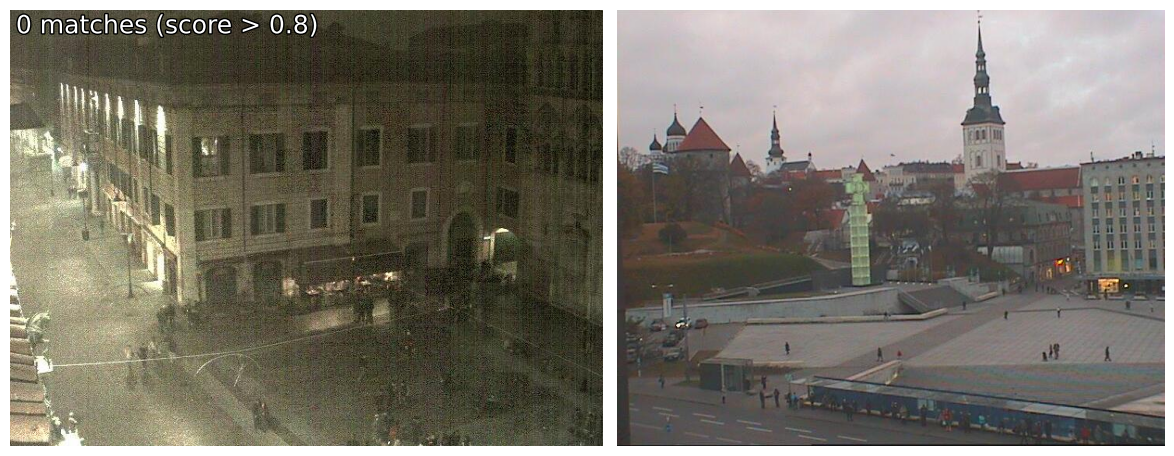

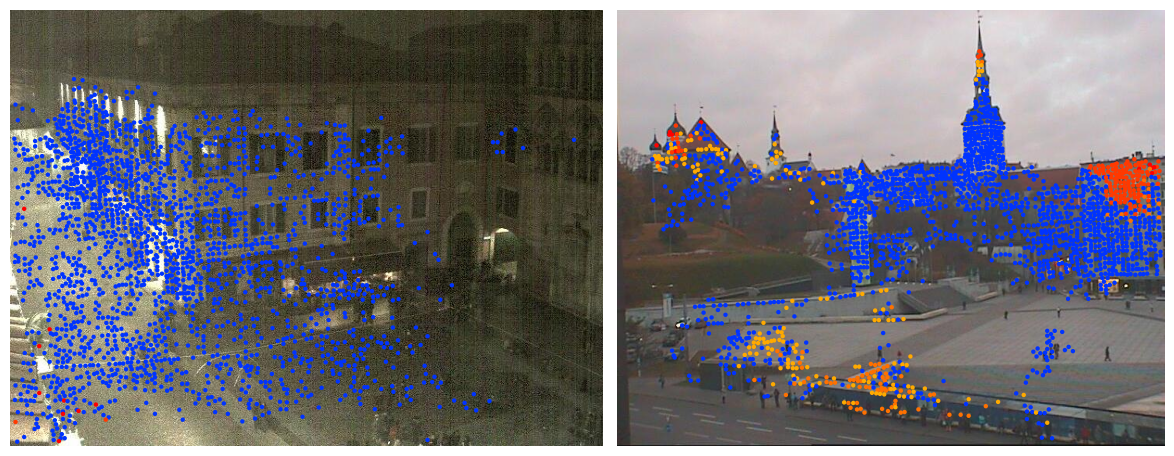

In [8]:
from lightglue import viz2d

kpts0, kpts1 = feats0["keypoints"], feats1["keypoints"]
matches = matches01["matches"]

m_kpts0 = kpts0[matches[..., 0]]
m_kpts1 = kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.3)

viz2d.add_text(
    0,
    f'{len(matches)} matches (score > 0.8)',
    fs=18
)

# Optional: visualize pruning confidence
kpc0 = viz2d.cm_prune(matches01["prune0"])
kpc1 = viz2d.cm_prune(matches01["prune1"])

viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)


In [6]:
import numpy as np
import cv2
import torch

# -----------------------------
# 1) Prepare matched points
# -----------------------------
pts0 = points0.detach().cpu().numpy().astype(np.float32)  # in image0 coords
pts1 = points1.detach().cpu().numpy().astype(np.float32)  # in image1 coords

if len(pts0) < 8:
    raise ValueError(f"Not enough matches for homography: {len(pts0)}")

# -----------------------------
# 2) Estimate homography H: image1 -> image0
# -----------------------------
H, inlier_mask = cv2.findHomography(pts1, pts0, cv2.RANSAC, 5.0)

if H is None:
    raise RuntimeError("Homography estimation failed. Lower threshold or check matches.")

inliers = int(inlier_mask.sum()) if inlier_mask is not None else 0
print("Homography inliers:", inliers, "/", len(pts0))

# -----------------------------
# 3) Convert torch images (3,H,W in [0,1]) to OpenCV uint8 (H,W,3 BGR)
# -----------------------------
def torch_to_cv_u8(img_t: torch.Tensor) -> np.ndarray:
    # img_t: (3,H,W), float [0,1]
    img = (img_t.permute(1, 2, 0).detach().cpu().numpy() * 255.0).clip(0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

img0_cv = torch_to_cv_u8(image0)
img1_cv = torch_to_cv_u8(image1)

h0, w0 = img0_cv.shape[:2]
h1, w1 = img1_cv.shape[:2]

# -----------------------------
# 4) Warp image1 into image0 geometry
# -----------------------------
img1_warp = cv2.warpPerspective(img1_cv, H, (w0, h0), flags=cv2.INTER_LINEAR)

# -----------------------------
# 5) Compute overlap mask and crop to overlap bounding rectangle
#    - overlap where both img0 and warped img1 have valid pixels
# -----------------------------
# Build validity mask for warped image1 (where pixels are not empty)
mask1 = cv2.warpPerspective(np.ones((h1, w1), dtype=np.uint8) * 255, H, (w0, h0))
mask0 = np.ones((h0, w0), dtype=np.uint8) * 255

overlap = cv2.bitwise_and(mask0, mask1)

ys, xs = np.where(overlap > 0)
if len(xs) == 0 or len(ys) == 0:
    raise RuntimeError("No overlap found after warping. Check matches / threshold.")

x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()

# Optional: tighten the crop a bit (remove border artifacts)
margin = 2
x_min = max(0, x_min + margin)
y_min = max(0, y_min + margin)
x_max = min(w0 - 1, x_max - margin)
y_max = min(h0 - 1, y_max - margin)

# -----------------------------
# 6) Crop aligned images
# -----------------------------
img0_crop = img0_cv[y_min:y_max+1, x_min:x_max+1]
img1_crop = img1_warp[y_min:y_max+1, x_min:x_max+1]

print("Aligned crop size:", img0_crop.shape, img1_crop.shape)

# -----------------------------
# 7) Save results
# -----------------------------
cv2.imwrite("aligned_img0.png", img0_crop)
cv2.imwrite("aligned_img1.png", img1_crop)

print("Saved: aligned_img0.png and aligned_img1.png")


Homography inliers: 354 / 354
Aligned crop size: (467, 636, 3) (467, 636, 3)
Saved: aligned_img0.png and aligned_img1.png
